# Demo: Deep Deterministic Policy Gradient (DDPG) Algorithm

## Implementation of Algorithm

In [1]:
# install relevant packages, if necessary
# !pip install torch gymnasium gymnasium[mujoco]
# !pip install "gymnasium[other]"
# ! pip install matplotlib

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import os
import datetime
from typing import List, Tuple

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action

        self.layer1 = nn.Linear(state_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, action_dim)

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        return self.max_action * x

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.layer1 = nn.Linear(state_dim + action_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

class ReplayBuffer:
    def __init__(self, max_size=1e6):
        self.buffer = deque(maxlen=int(max_size))

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward.reshape(-1, 1), next_state, done.reshape(-1, 1)

    def __len__(self):
        return len(self.buffer)

class DDPG:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer()

        # Add tracking of losses
        self.critic_losses = []
        self.actor_losses = []
        self.q_values = []

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.actor(state).cpu().data.numpy().flatten()

    def update(self, batch_size=64, gamma=0.99, tau=0.001):
        if len(self.replay_buffer) < batch_size:
            return None, None, None

        # Sample a batch from memory
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = \
            self.replay_buffer.sample(batch_size)

        # Convert to torch tensors
        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.FloatTensor(action_batch)
        reward_batch = torch.FloatTensor(reward_batch)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(done_batch)

        # Compute the target Q value
        next_action_batch = self.actor_target(next_state_batch)
        target_Q = self.critic_target(next_state_batch, next_action_batch)
        target_Q = reward_batch + ((1 - done_batch) * gamma * target_Q).detach()

        # Get current Q estimate
        current_Q = self.critic(state_batch, action_batch)

        # Compute critic loss
        critic_loss = nn.MSELoss()(current_Q, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -self.critic(state_batch, self.actor(state_batch)).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        # Store metrics
        self.critic_losses.append(critic_loss.item())
        self.actor_losses.append(actor_loss.item())
        self.q_values.append(current_Q.mean().item())

        return critic_loss.item(), actor_loss.item(), current_Q.mean().item()


In [4]:
def plot_metrics(rewards, critic_losses, actor_losses, q_values):
    """Plot training metrics."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    # Plot rewards
    ax1.plot(rewards)
    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')

    # Plot critic loss
    ax2.plot(critic_losses)
    ax2.set_title('Critic Loss')
    ax2.set_xlabel('Update Step')
    ax2.set_ylabel('Loss')

    # Plot actor loss
    ax3.plot(actor_losses)
    ax3.set_title('Actor Loss')
    ax3.set_xlabel('Update Step')
    ax3.set_ylabel('Loss')

    # Plot Q-values
    ax4.plot(q_values)
    ax4.set_title('Average Q-values')
    ax4.set_xlabel('Update Step')
    ax4.set_ylabel('Q-value')

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    return fig


## Train DDPG Agent

In [5]:
def train_ddpg(
    environment,
    max_episodes = 2000,
    max_steps = 1000,
    batch_size = 128,
):
    """
    Train a DDPG agent on a specified environment.

    Args:
        max_episodes (int): Maximum number of episodes to train for
        max_steps (int): Maximum number of steps per episode
        batch_size (int): Size of batches sampled from replay buffer
        environment (str): Name of the Gymnasium environment to use

    Returns:
        Tuple[DDPG, List[float]]: Trained agent and list of episode rewards
    """

    env = gym.make(environment)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPG(state_dim, action_dim, max_action)
    episode_rewards = []

    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)

            # Add exploration noise
            action = action + np.random.normal(0, 0.05, size=action_dim)
            action = action.clip(env.action_space.low, env.action_space.high)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, done)

            if len(agent.replay_buffer) > batch_size:
                agent.update(batch_size)

            state = next_state
            episode_reward += reward

            if done:
                break

        episode_rewards.append(episode_reward)

        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode + 1}, Reward: {episode_reward:.2f}")
            # Plot metrics every 10 episodes
            plot_metrics(episode_rewards, agent.critic_losses, agent.actor_losses, agent.q_values)

    return agent, episode_rewards


Episode: 10, Reward: -225.29
Episode: 20, Reward: 72.04
Episode: 30, Reward: -172.58
Episode: 40, Reward: 427.97
Episode: 50, Reward: 654.46


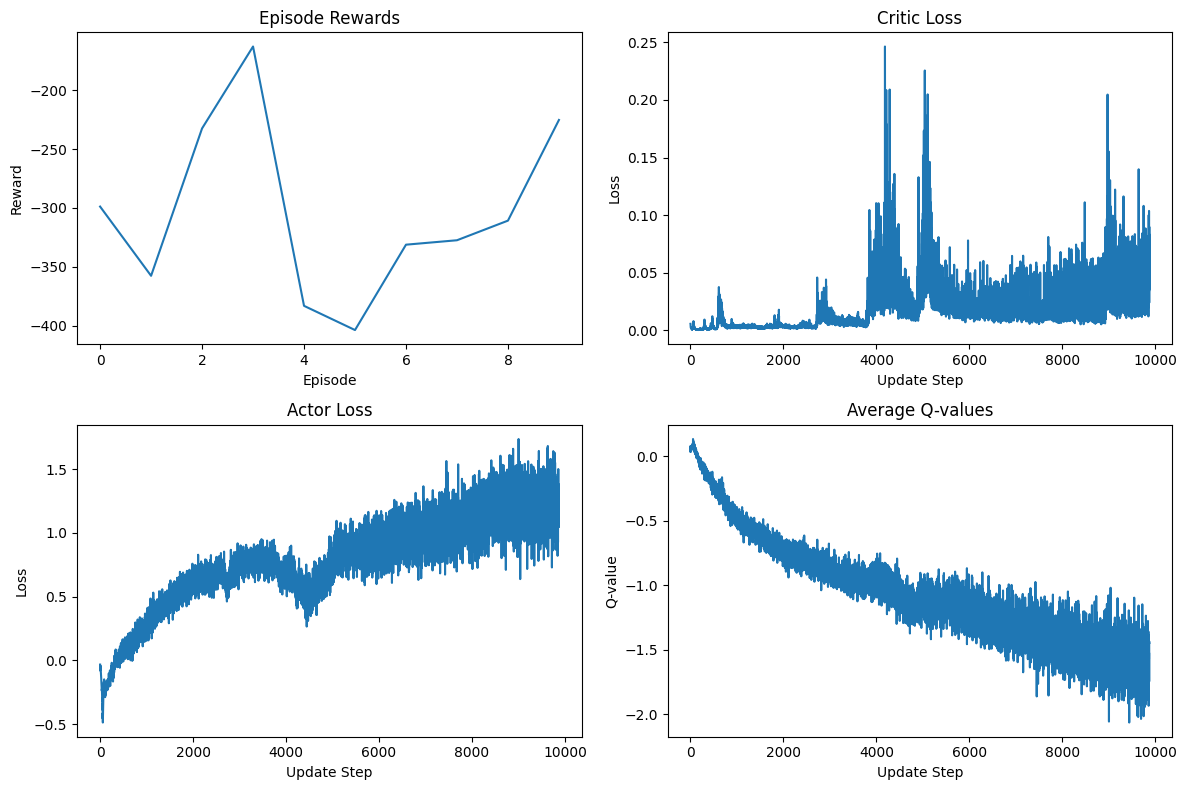

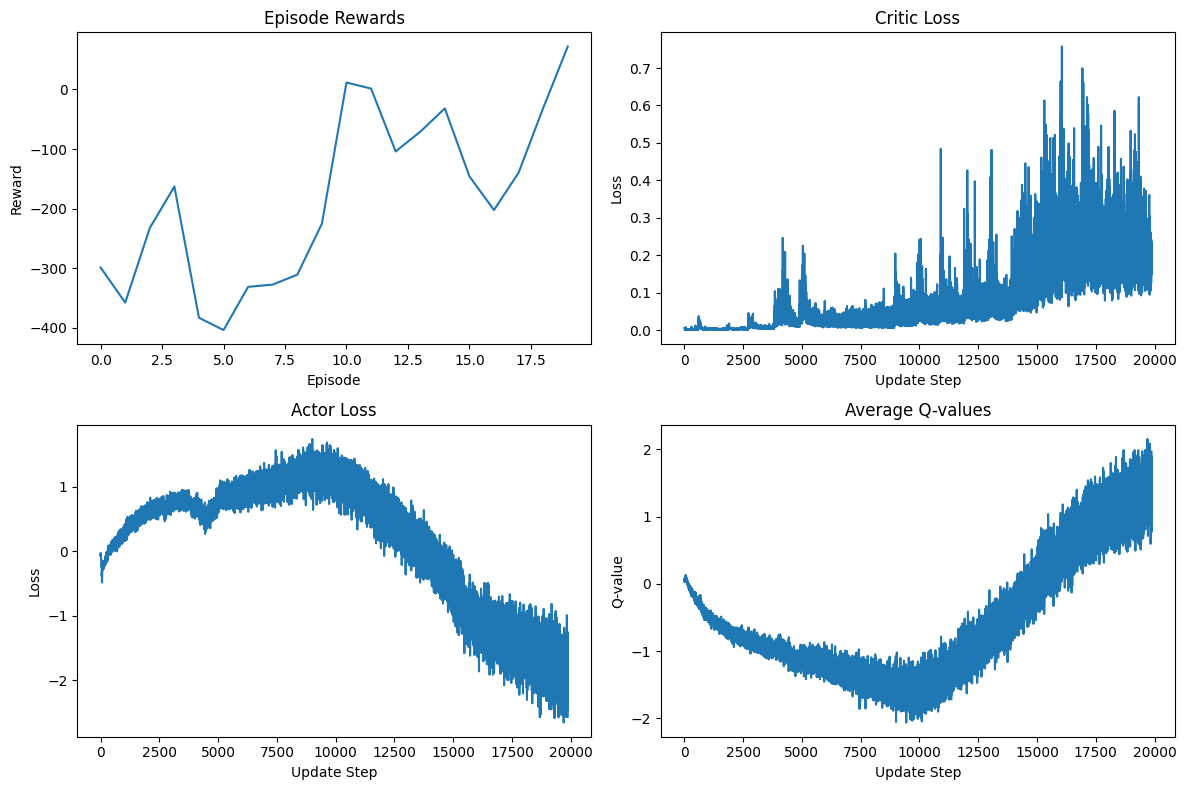

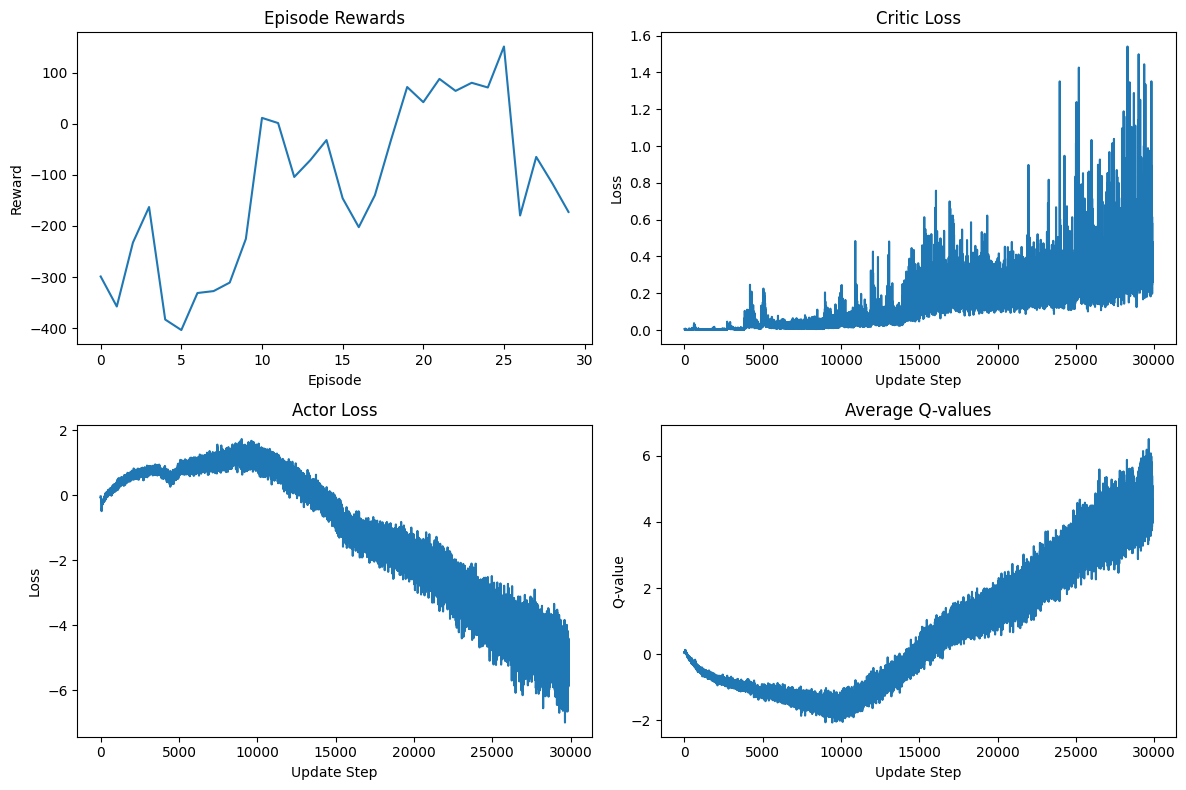

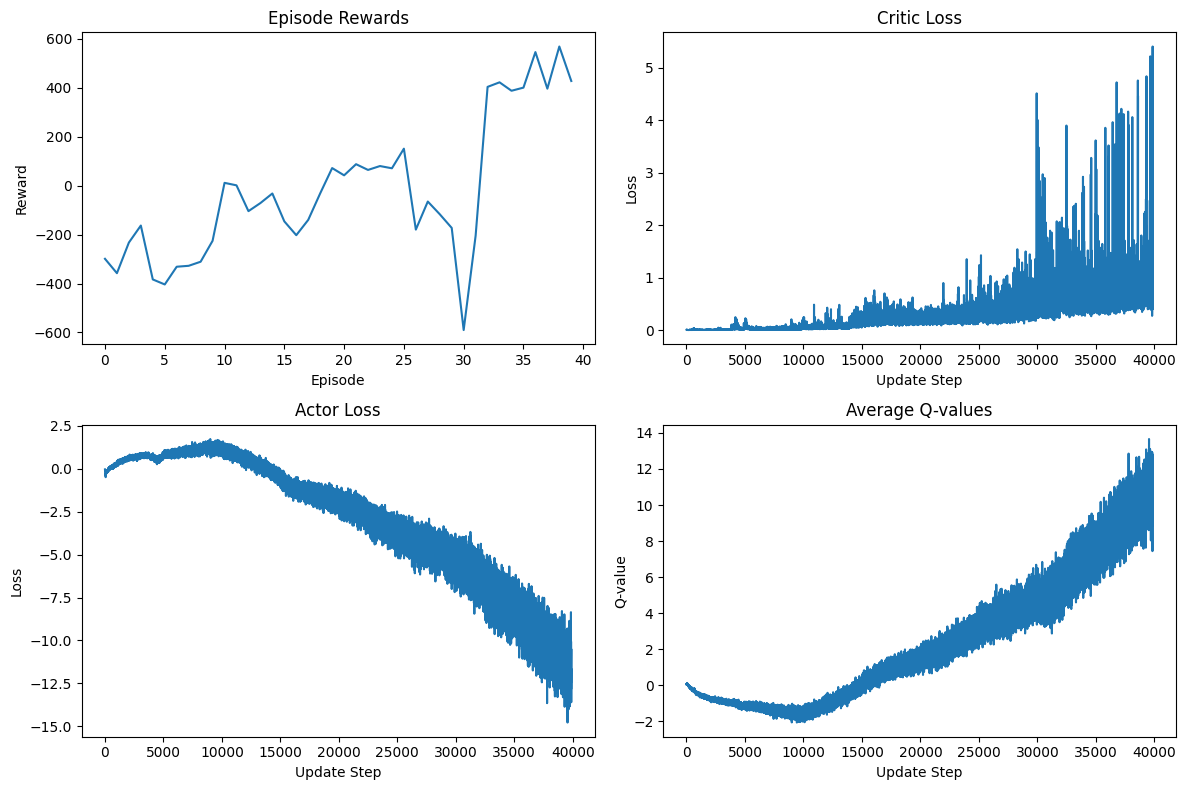

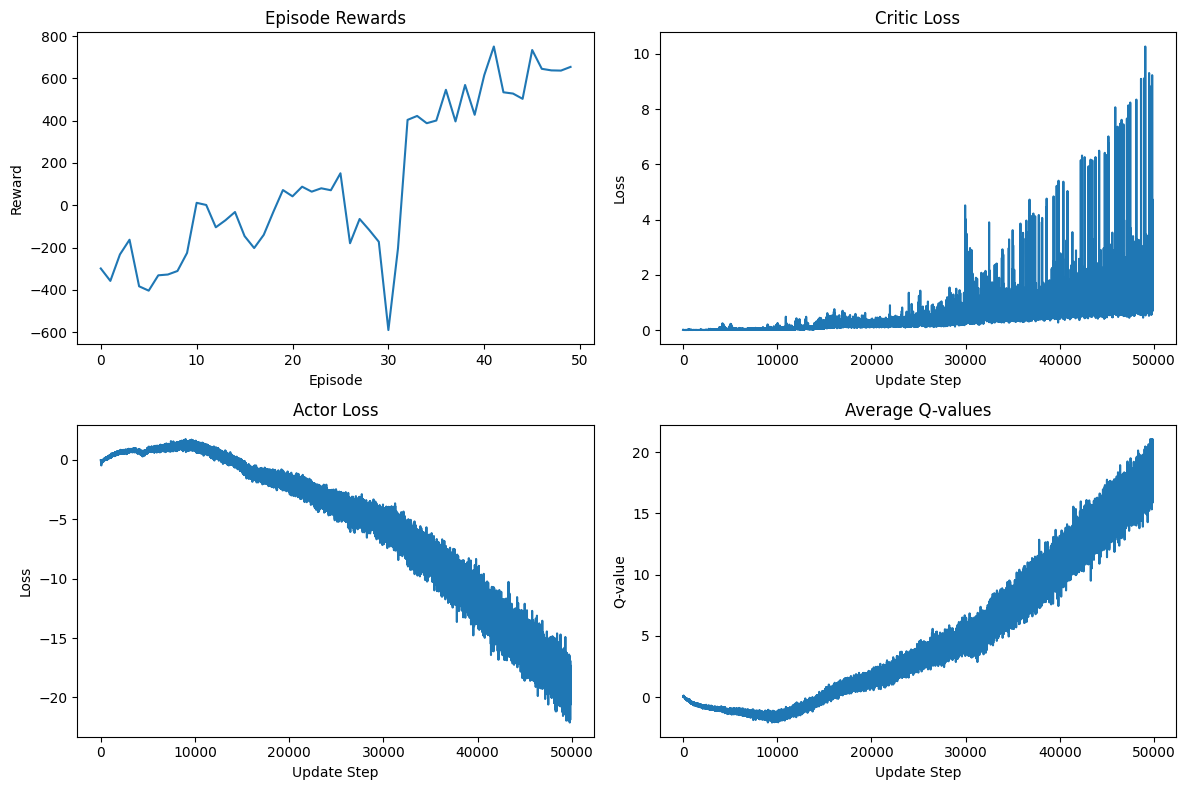

In [6]:
# Train the agent

# try increasing the number of training episodes, changing the environment, etc.
environment = "HalfCheetah-v5"
agent, rewards = train_ddpg(environment, max_episodes=50)

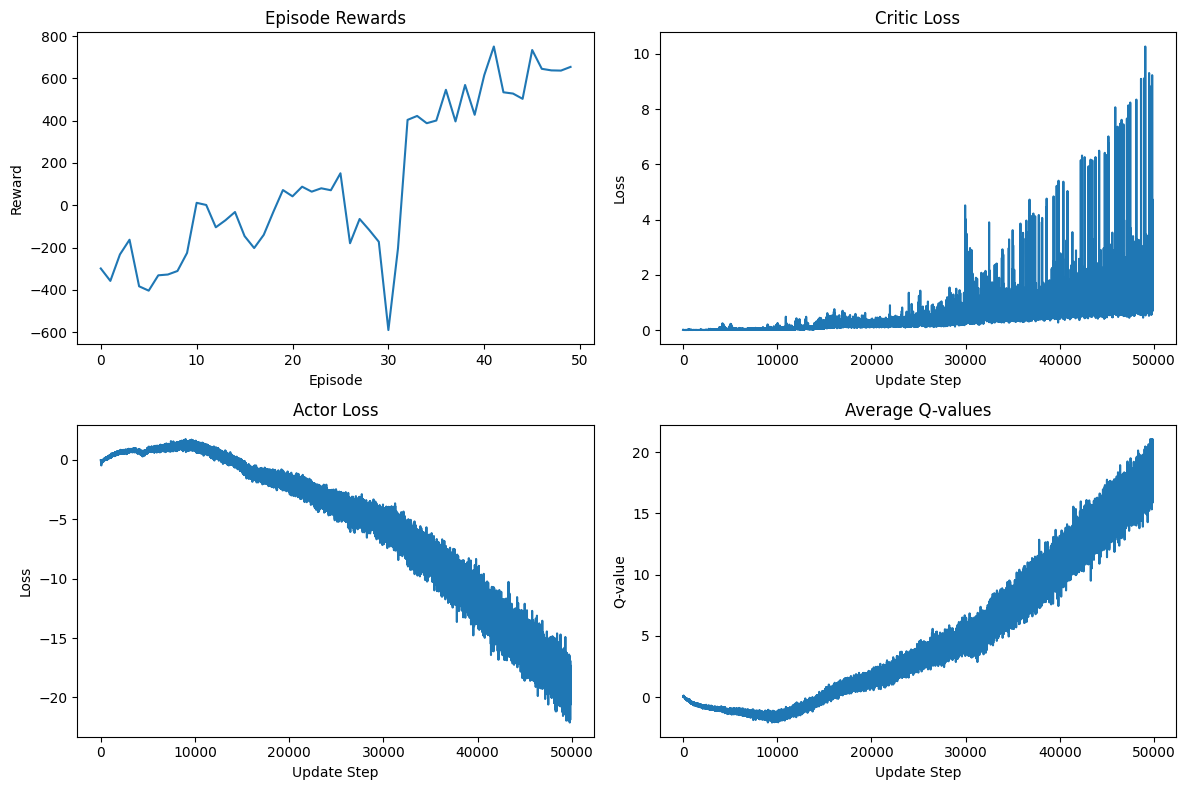

In [7]:
fig = plot_metrics(rewards, agent.critic_losses, agent.actor_losses, agent.q_values)

## Demo Trained Agent

In [8]:
def record_video(
    agent,
    environment,
    video_length = 250
):
    """
    Record a video of the trained agent.

    Args:
        agent (DDPG): Trained DDPG agent
        environment (str): Name of the Gymnasium environment to use
        video_length (int): Maximum length of the recording
    """

    env = gym.make(environment, render_mode='rgb_array')
    env = RecordVideo(env, video_folder='videos',
        episode_trigger=lambda x: True,
        name_prefix=f"ddpg_trained_agent_demo")

    state, _ = env.reset()
    total_reward = 0

    for _ in range(video_length):
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    env.close()
    print(f"Video recording completed with total reward: {total_reward:.2f}")


In [9]:
record_video(agent, environment)

/home/ma2393/.conda/envs/rl_course/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /gpfs/gibbs/project/lafferty/ma2393/RL_course/rl_algorithm_implementations/DDPG/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Video recording completed with total reward: 182.26


In [10]:
from IPython.display import Video
Video('videos/ddpg_trained_agent_demo-episode-0.mp4', embed=True)